In [1]:
#@title << Setup Google Colab by running this cell {display-mode: "form"}
import sys
if 'google.colab' in sys.modules:
    # Clone GitHub repository
    !git clone https://github.com/pxydi/text.git
        
    # Copy files required to run the code
    !cp -r "text/data" "text/plots" "text/tools.py" .
    
    # Install packages via pip
    !pip install -r "text/colab-requirements.txt"
    
    # Restart Runtime
    import os
    os.kill(os.getpid(), 9)

# Text similarity

In the previous notebook, we transformed samples of text into lists of numbers using various methods. In each of these methods, the numbers in the vectors are defined somehow differently: 
* in Bag of words, they correspond to word counts.
* in Tf-idf, they correspond to word counts, re-weighted by the *inverse document frequency*.
* in sentence embeddings, they are learned from the data using an "embedding method" in such a way that they encode semantic relationships; similar texts have similar embeddings.

## Visualize data

We already mentionned that we can think of these lists of numbers as points in (a high-dimensional) space. We can plot them and try to look for patterns, i.e. clusters of similar documents.

However, we can only plot in 2 or 3 dimensions, not more. This means that we need to perform "dimensionality reduction", which consists in "compressing" the data into few 2 (or 3) dimensions without losing too much information. 

In [2]:
# Load libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random, re, os
import contractions

import tools

In [3]:
# Load data

path = os.path.join('data','clean_sentiment_140.csv')
df   = pd.read_csv(path)

# Show a few samples
df.head()

,tweet,processed_tweet,label,semantic_category
0,"@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right.",looovvvee kindl not dx cool fantast right,pos,books
1,Reading my kindle2... Love it... Lee childs is good read.,read kindl love lee child good read,pos,books
2,"Ok, first assesment of the #kindle2 ...it fucking rocks!!!",ok first asses kindl fuck rock,pos,books
3,@kenburbary You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! :),love kindl mine month never look back new big one huge no need remors :),pos,books
4,@mikefish Fair enough. But i have the Kindle2 and I think it's perfect :),fair enough kindl think perfect :),pos,books


In [4]:
# Load word vectors

with np.load('data/word_vectors.npz',allow_pickle=False) as data:
    X_bow   = data['BOW_features']
    X_tfidf = data['tfidf_features']
    X_embed = data['embeddings']
    
print('Data loaded.')
print('BOW features: ',X_bow.shape)
print('Tf-idf features: ',X_tfidf.shape)
print('Embeddings: ',X_embed.shape)

Data loaded.
BOW features:  (498, 300)
Tf-idf features:  (498, 300)
Embeddings:  (498, 512)


## Visualize data

Machine learning can help with data visualization. A few popular techniques are

- [Principal component analysis](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
- [Truncated SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)
- [T-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

In [5]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline

decomp = make_pipeline(PCA(n_components=40), TSNE(n_components=2))

# BOW features
X_decomp_bow   = decomp.fit_transform(X_bow)

# Embeddings
X_decomp_embed = decomp.fit_transform(X_embed)

print(X_decomp_bow.shape)

(498, 2)


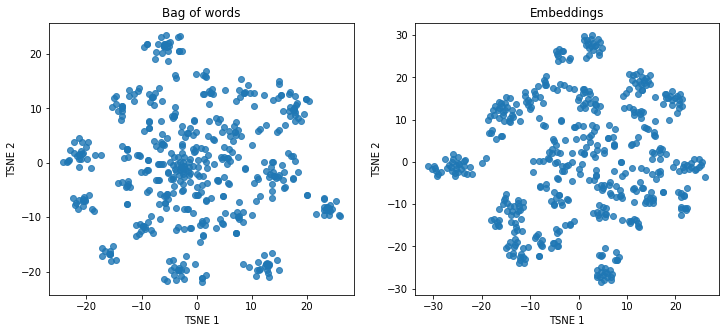

In [6]:
# Plot results
fig,axes = plt.subplots(1,2,figsize=(12,5))

#Plot X_decomp_bow
axes[0].scatter(X_decomp_bow[:,0],X_decomp_bow[:,1],alpha=0.8)
axes[0].set_xlabel('TSNE 1')
axes[0].set_ylabel('TSNE 2');
axes[0].set_title('Bag of words');

#Plot X_decomp_embed
axes[1].scatter(X_decomp_embed[:,0],X_decomp_embed[:,1],alpha=0.8)
axes[1].set_xlabel('TSNE 1')
axes[1].set_ylabel('TSNE 2');
axes[1].set_title('Embeddings');

Let's focus ...

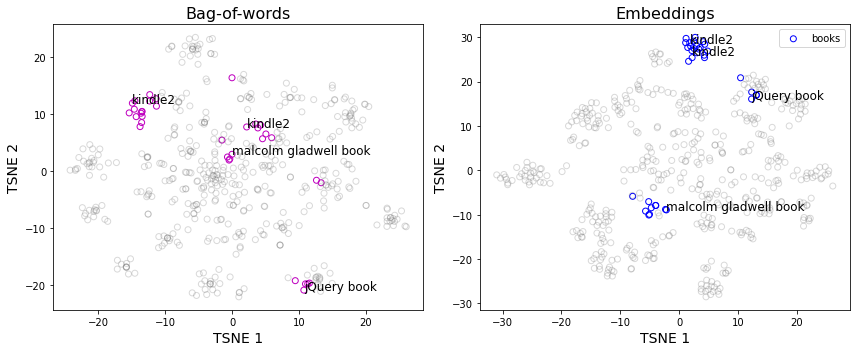

In [7]:
selected_labels = ['movies','Twitter', 'politics', 'sports', 'IT', 'books']

tools.visualize_bow_embeddings(X_decomp_bow,X_decomp_embed,df,label='books')

Each point in the plot represents a tweet. Using ML here has allowed grouping together tweets that are discussing the same topic. For example, we can see that tweets talking about Obama, North Korea, Iran, or China (i.e. politics) are grouped in the lower right corner of the plot. Similarly, tweets about (American) cable tv (Time Warner, ESPN, or Comcast) all appear together in the top right corner. In fact, there are many such groups in this plot (about movies, sports, food, etc).
What I like about it is that an algorithm has managed to capture semantic relationships between tweets, even if the tweets don’t use the same words. The ML algorithms used are capable of detecting similarities between e.g. “Night at the museum” and “Star Trek”, and then putting them close to each other in the plot. We, humans, would have to read all of these tweets (several thousand) and assign them to different groups one by one. ML can do this in two lines of code!


So, Bag of words, will determine similarity based on the words.

## Distance between vectors

Two vectors are similar if they point in the same direction. In a word space, this means that two documents use the same words, in the same proportions, hence they are likely to be discussing the same thing.

The idea is that if documents use the same words in the same proportions, then their document vecrors will be closeby in the word space; they will be pointing in the same direction and having similar lengths.

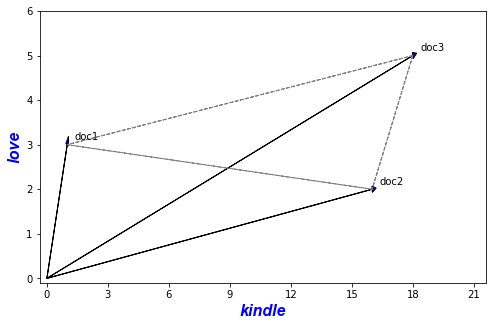

In [8]:
# Toy vectors

doc1 = np.array([1,3])
doc2 = np.array([16,2])
doc3 = np.array([18,5])

docs = np.zeros((1,2))

for doc in [doc1,doc2,doc3]:
    docs = np.vstack((docs,doc))
    
docs = docs[1:]
tools.plot_vectors(doc1,doc2,doc3,plot_difference=True)

We can compare vectors using: 
* the euclidean distance
* the cosine similarity

### Euclidean distance 

The euclidean distance is simply the distancee between two vectors.

In [9]:
from sklearn.metrics.pairwise import euclidean_distances

In [10]:
index_labels = ['doc'+str(i+1) for i in range(0,3)]
column_labels = index_labels

pd.DataFrame(euclidean_distances(docs), index = index_labels, columns = column_labels)

,doc1,doc2,doc3
doc1,0.000000,15.033296,17.117243
doc2,15.033296,0.000000,3.605551
doc3,17.117243,3.605551,0.000000


However, the euclidean distance can be misleading if used to compare vectors of different lengths. It's better to use the Euclidean distance with vectors of the same length. We will fist normalize the document vectors (ensuring they all have a length of 1) and will recompute the Euclidean distance. 

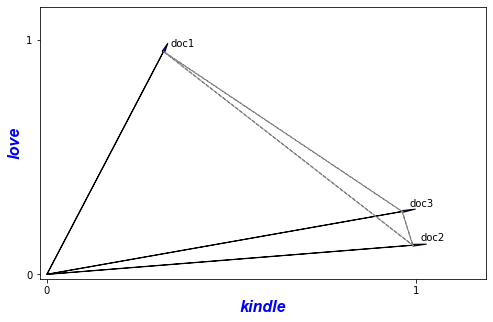

In [13]:
# Plot normalized vectors

tools.plot_vectors(tools.normalize_vector(doc1),
                   tools.normalize_vector(doc2),
                   tools.normalize_vector(doc3),
                   plot_difference=True)

In [15]:
# Compute euclidean distances using normalized vectors

pd.DataFrame(euclidean_distances(tools.normalize_vector(docs)), index = index_labels, columns = column_labels)

,doc1,doc2,doc3
doc1,0.000000,1.066344,0.939574
doc2,1.066344,0.000000,0.146461
doc3,0.939574,0.146461,0.000000


### Cosine similarity

We saw that the Euclidean distance can be affected by the vectors' length. The cosine similarity is another commonly used metric to mesure document similarity, which isn't affected by the vectors' length.

The cosine similarity expresess the cosine of the angle between two vectors. 

* If the angle between two vectors is small (𝜽 -> 0), then the cosine of 𝜽 will be close to 1. 
* If the angle between two vectors is big (𝜽 -> 90), then the cosine of 𝜽 will be close to 0.

In [16]:
from sklearn.metrics.pairwise import cosine_similarity

In [17]:
# Compute the cosine similarity

pd.DataFrame(cosine_similarity(docs), index = index_labels, columns = column_labels)

,doc1,doc2,doc3
doc1,1.000000,0.431455,0.558600
doc2,0.431455,1.000000,0.989275
doc3,0.558600,0.989275,1.000000


In [19]:
pd.DataFrame(euclidean_distances(tools.normalize_vector(docs)), index = index_labels, columns = column_labels)

,doc1,doc2,doc3
doc1,0.000000,1.066344,0.939574
doc2,1.066344,0.000000,0.146461
doc3,0.939574,0.146461,0.000000


Let's compare our tweets using the Twitter dataset. 

In [20]:
# Select features Features

X = X_embed
X[0:3]

array([[-0.00288029, -0.00125515,  0.06025296, ..., -0.0729619 ,
         0.05669533, -0.01598459],
       [ 0.01854019, -0.04968135,  0.06467673, ..., -0.09140924,
         0.0719011 , -0.03177943],
       [-0.02455723, -0.04732381,  0.01274171, ..., -0.07947366,
         0.063754  ,  0.00292308]], dtype=float32)

In [21]:
# TODO: Try also with cosine similarity
#similarity_df = pd.DataFrame(euclidean_distances(normalize_vector(X)))
similarity_df = pd.DataFrame(cosine_similarity(X))

similarity_df.index   = ['doc_'+str(i) for i in range(0,len(X))]
similarity_df.columns = ['doc_'+str(i) for i in range(0,len(X))]

similarity_df.head()

,doc_0,doc_1,doc_2,doc_3,doc_4,doc_5,doc_6,doc_7,doc_8,doc_9,...,doc_488,doc_489,doc_490,doc_491,doc_492,doc_493,doc_494,doc_495,doc_496,doc_497
doc_0,1.000000,0.571789,0.667258,0.724427,0.701751,0.670048,-0.034675,0.082130,0.110060,-0.005169,...,-0.020800,0.114550,0.322850,0.357997,0.260232,0.157971,0.279629,0.300884,-0.049279,-0.020887
doc_1,0.571789,1.000000,0.684134,0.648859,0.545934,0.546725,0.043274,0.212008,0.190413,0.116632,...,0.017390,0.164838,0.229025,0.291189,0.133923,0.103846,0.253879,0.231040,0.020367,0.197550
doc_2,0.667258,0.684134,1.000000,0.710352,0.614419,0.590150,0.028603,0.199056,0.211342,0.007821,...,0.061898,0.193357,0.252206,0.336561,0.183844,0.124607,0.292712,0.264402,0.048984,0.152273
doc_3,0.724427,0.648859,0.710352,1.000000,0.736682,0.759968,0.061765,0.161975,0.137676,0.044058,...,0.050649,0.154608,0.306790,0.352758,0.175299,0.115301,0.250594,0.237592,-0.015610,0.054416
doc_4,0.701751,0.545934,0.614419,0.736682,1.000000,0.741376,0.004079,0.098047,0.049026,0.020797,...,0.028081,0.076425,0.263010,0.330680,0.210513,0.165457,0.274900,0.313627,0.026576,0.004394


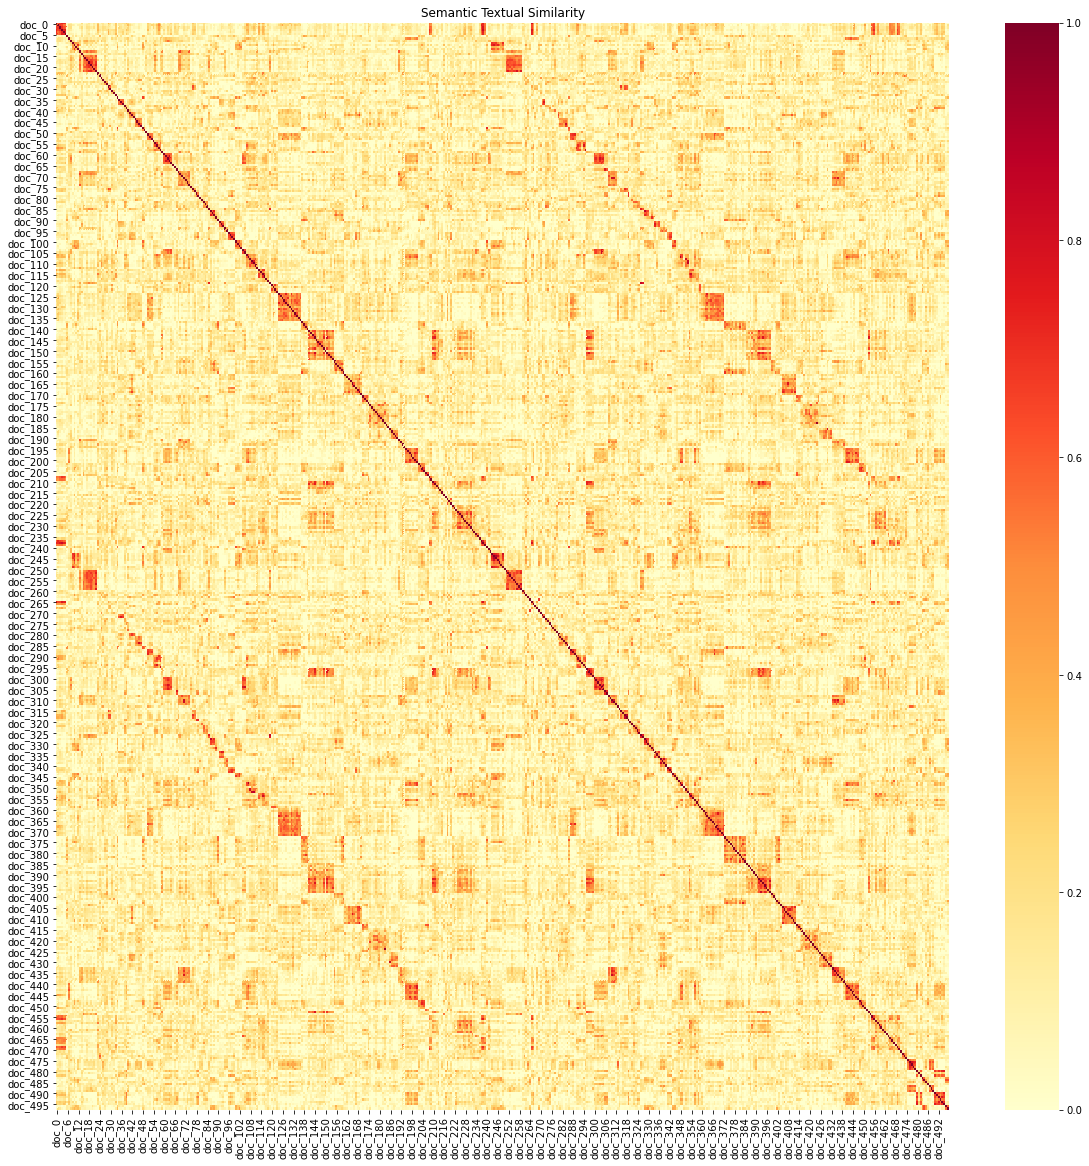

In [24]:
# Plot similarity metric using heatmaps

tools.plot_similarity(similarity_df)

In [26]:
def find_neighbohrs(idx,X,data = df):
    
    neighbohrs_df = pd.DataFrame()
    
    df_cos  = pd.DataFrame(cosine_similarity(X))
    df_dist = pd.DataFrame(euclidean_distances(tools.normalize_vector(X)))
    
    # Sort neighbors with respect to cosine similarity
    neighborhs = np.argsort(df_cos.iloc[idx,:])[::-1]
    
    neighbohrs_df['processed_tweet'] = df.iloc[neighborhs,1]
    neighbohrs_df['cosine_similarity'] = df_cos.iloc[idx,neighborhs]
    neighbohrs_df['euclidean_distance'] = df_dist.iloc[idx,neighborhs]
    neighbohrs_df['label'] = df.iloc[neighborhs,-2]
    neighbohrs_df['semantic_category'] = df.iloc[neighborhs,-1]

    return neighbohrs_df.head(10)
 
# Randomly sampled tweet

idx = random.randint(0,len(df)-1)
print('Doc idx: {}'.format(idx))

pd.set_option('max_colwidth', None)
find_neighbohrs(idx,X_embed)

Doc idx: 203


,processed_tweet,cosine_similarity,euclidean_distance,label,semantic_category
203,great someon sit shade today someon plant tree long time ago warren_buffet,1.000000,0.000000,pos,Warren Buffett
449,super investor great weekend read warren_buffet oldi goodi,0.531930,0.967543,pos,Warren Buffett
205,warren_buffet becam time richest man unit state not work invest big idea lead fortun,0.519691,0.980112,pos,Warren Buffett
204,warren_buffet economi,0.482835,1.017020,neutral,Warren Buffett
448,buffet warren buffett kick butt battl boot post alex cripp,0.450812,1.048034,neutral,Warren Buffett
202,right lol get high expect warren_buffet style,0.449773,1.049025,pos,Warren Buffett
90,burn cash chrysler gm stop financi tsunami bailout mean take handout,0.399904,1.095533,neg,car industry
450,truli braindead could not come warren_buffet name save soul,0.385333,1.108754,neutral,Warren Buffett
486,twitter stock buzz aapl es_f spi spx palm updat pm,0.377745,1.115576,neutral,Twitter
451,read michael palin book python yearsgreat book also recommend warren_buffet nelson mandela bio,0.367693,1.124550,pos,Warren Buffett


In [27]:
np.linalg.norm(X_tfidf,axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [28]:
np.linalg.norm(X_bow[np.argsort(np.linalg.norm(X_bow,axis=1))][0:50],axis=1)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.41421356, 1.41421356, 1.41421356, 1.41421356, 1.41421356])

In [29]:
np.linalg.norm(X_tfidf[np.argsort(np.linalg.norm(X_tfidf,axis=1))][0:50],axis=1)

array([0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [30]:
np.argsort(np.linalg.norm(X_bow,axis=1))

array([113,  65,  66, 117, 346, 240, 409, 197, 199, 461, 308, 204, 407,
        56, 325,  46, 200, 195, 448, 328, 188, 301, 446, 100, 436, 431,
       168, 166, 275, 425, 423, 161, 419, 190,  36, 314, 223, 355,  19,
       484, 229, 393, 242, 480, 483, 360, 284, 181, 183, 185, 294, 103,
       297, 101, 299, 300,  35, 488, 302,  17, 295, 345, 177, 120, 418,
       153, 241, 421, 269, 415, 493, 424, 375, 389, 165, 428, 429, 233,
       279,   8, 432, 412, 262, 125, 124, 437, 281,  91, 303,  96, 189,
        61, 406,  89, 336,  55, 324, 335, 400,  50,  62, 399, 216, 383,
       329,  42,  41, 330, 382, 472, 398,  47,  63,  59, 159, 459, 321,
       198, 392, 155,  21, 363, 194, 410, 255, 358,  86,  18, 365, 192,
       416, 252, 227, 413, 264, 237, 397, 385, 228, 180, 401, 179, 224,
       182, 175, 174, 258, 187, 404, 386, 173, 172, 411, 408, 169, 403,
       232, 176, 283, 471, 304,  87, 305,  84,  83, 311, 368, 417,  25,
       460, 102,  72,  68,  64, 362,  58, 361, 475,  52, 327, 46

In [31]:
df.iloc[[113, 117, 346,  66]]

,tweet,processed_tweet,label,semantic_category
113,zomg!!! I have a G2!!!!!!!,zomg,pos,unlabeled
117,At GWT fireside chat @googleio,gwt firesid chat,neutral,unlabeled
346,Absolutely hilarious!!! from @mashable: http://bit.ly/bccWt,absolut hilari,pos,unlabeled
66,is scrapbooking with Nic =D,scrapbook nic =d,pos,unlabeled


In [32]:
df.iloc[[113,  65,  66, 117, 346]]

,tweet,processed_tweet,label,semantic_category
113,zomg!!! I have a G2!!!!!!!,zomg,pos,unlabeled
65,yahoo answers can be a butt sometimes,yahoo answer butt sometim,neg,unlabeled
66,is scrapbooking with Nic =D,scrapbook nic =d,pos,unlabeled
117,At GWT fireside chat @googleio,gwt firesid chat,neutral,unlabeled
346,Absolutely hilarious!!! from @mashable: http://bit.ly/bccWt,absolut hilari,pos,unlabeled
